In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from collections import defaultdict
import warnings

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/countifs/kaggle/main/6.%20Cirrhosis%20Prediction%20Dataset/cirrhosis.csv')

In [ ]:
df.head()

In [ ]:
df['Age'] = df['Age']/365

In [ ]:
df['Age'] = df['Age'].astype('int64')

In [ ]:
df['Age']

0      58
1      56
2      70
3      54
4      38
       ..
413    67
414    39
415    57
416    58
417    53
Name: Age, Length: 418, dtype: int64

In [ ]:
df.isna().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

<AxesSubplot:>

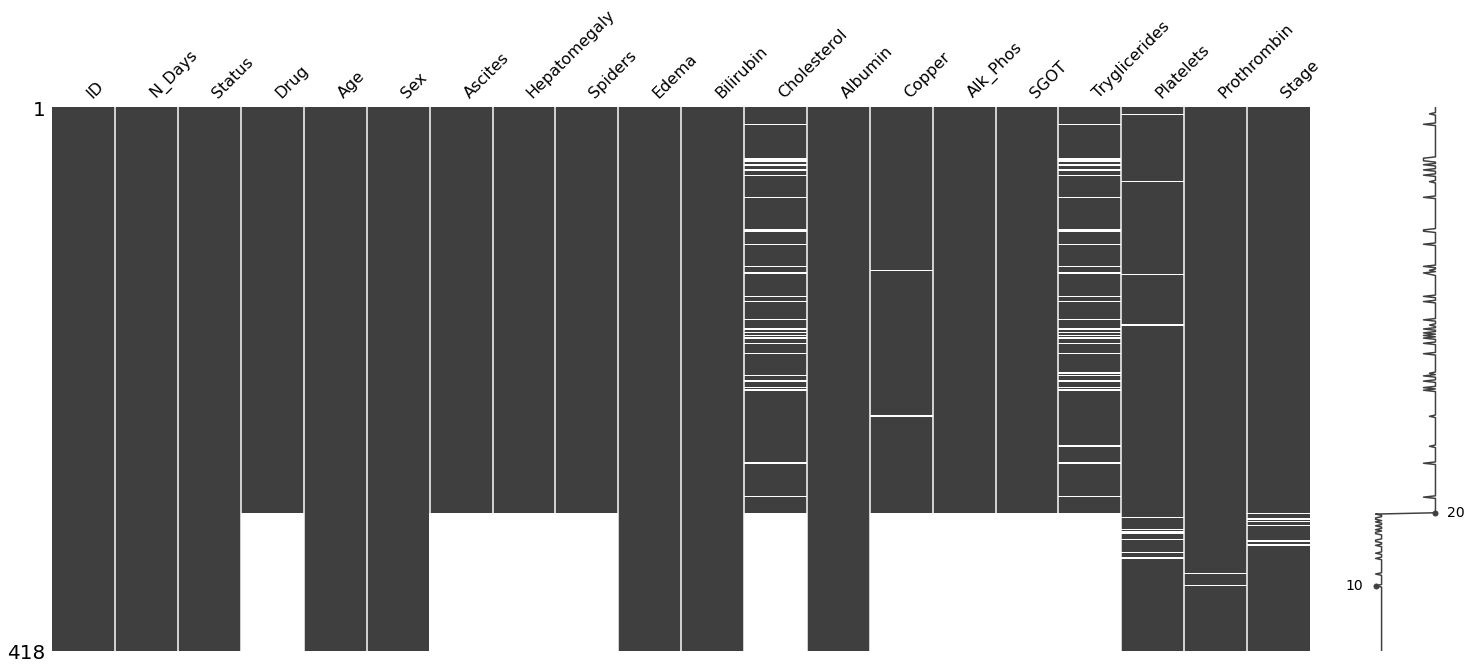

In [ ]:
msno.matrix(df)

In [ ]:
df.dropna(inplace=True)

<AxesSubplot:>

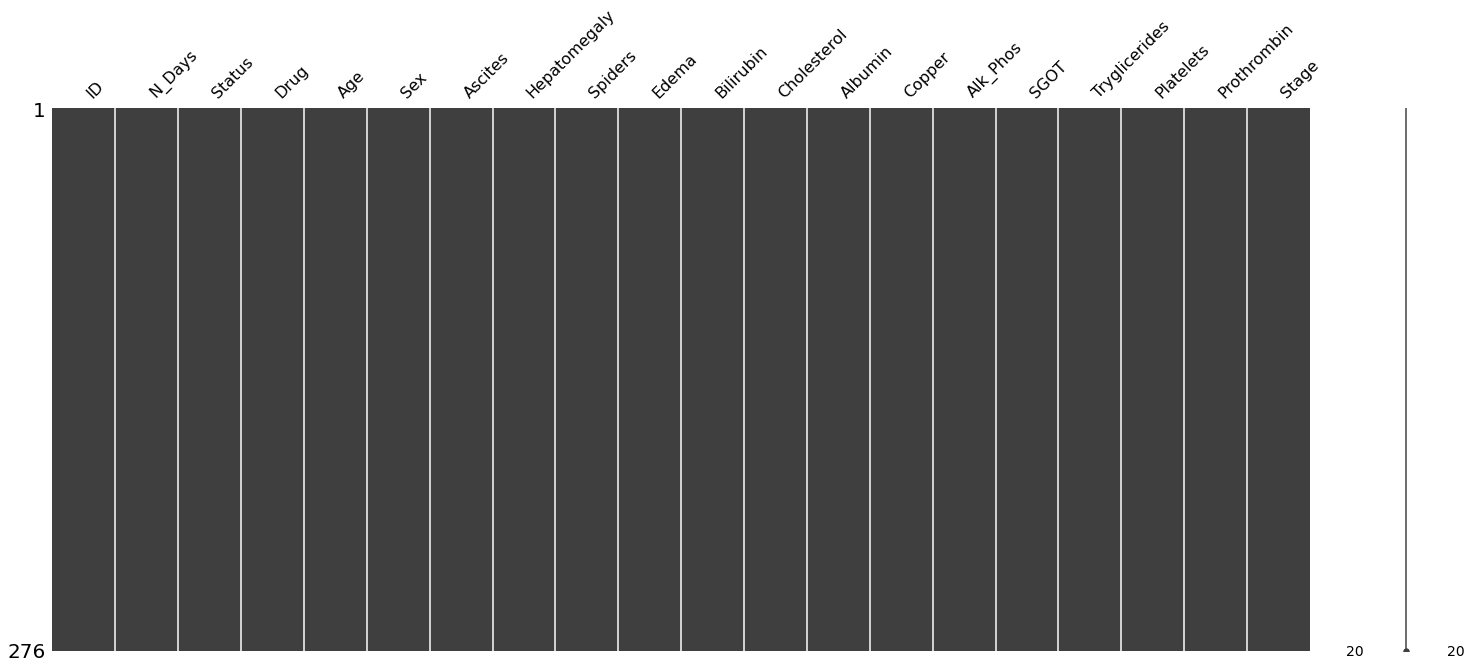

In [ ]:
msno.matrix(df)

In [ ]:
# 'object' Class 값 확인
df_object_columns = df.select_dtypes(include=['object']).columns
print()

for i in df_object_columns:
    print('컬럼명 : ', i )
    print(df[i].value_counts())
    print("=================================")
    print()


컬럼명 :  Status
C     147
D     111
CL     18
Name: Status, dtype: int64

컬럼명 :  Drug
Placebo            140
D-penicillamine    136
Name: Drug, dtype: int64

컬럼명 :  Sex
F    242
M     34
Name: Sex, dtype: int64

컬럼명 :  Ascites
N    257
Y     19
Name: Ascites, dtype: int64

컬럼명 :  Hepatomegaly
Y    142
N    134
Name: Hepatomegaly, dtype: int64

컬럼명 :  Spiders
N    196
Y     80
Name: Spiders, dtype: int64

컬럼명 :  Edema
N    234
S     25
Y     17
Name: Edema, dtype: int64



In [ ]:
df['Stage'] = df['Stage'].astype('int64')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 0 to 311
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             276 non-null    int64  
 1   N_Days         276 non-null    int64  
 2   Status         276 non-null    object 
 3   Drug           276 non-null    object 
 4   Age            276 non-null    int64  
 5   Sex            276 non-null    object 
 6   Ascites        276 non-null    object 
 7   Hepatomegaly   276 non-null    object 
 8   Spiders        276 non-null    object 
 9   Edema          276 non-null    object 
 10  Bilirubin      276 non-null    float64
 11  Cholesterol    276 non-null    float64
 12  Albumin        276 non-null    float64
 13  Copper         276 non-null    float64
 14  Alk_Phos       276 non-null    float64
 15  SGOT           276 non-null    float64
 16  Tryglicerides  276 non-null    float64
 17  Platelets      276 non-null    float64
 18  Prothrombi

In [ ]:
df['Stage'].dtype

dtype('int64')

In [ ]:
df['Stage'].value_counts()

3    111
4     94
2     59
1     12
Name: Stage, dtype: int64

In [ ]:
df.drop(columns='ID', inplace = True)

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
df

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,58,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4
1,4500,C,D-penicillamine,56,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3
2,1012,D,D-penicillamine,70,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4
3,1925,D,D-penicillamine,54,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4
4,1504,CL,Placebo,38,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,1153,C,D-penicillamine,61,F,N,Y,N,N,0.4,246.0,3.58,24.0,797.0,91.00,113.0,288.0,10.4,2
272,994,C,Placebo,58,F,N,N,N,N,0.4,260.0,2.75,41.0,1166.0,70.00,82.0,231.0,10.8,2
273,939,C,D-penicillamine,62,F,N,N,N,N,1.7,434.0,3.35,39.0,1713.0,171.00,100.0,234.0,10.2,2
274,839,C,D-penicillamine,38,F,N,N,N,N,2.0,247.0,3.16,69.0,1050.0,117.00,88.0,335.0,10.5,2


In [ ]:
df_export = df.drop(columns='N_Days')

In [ ]:
df_export

,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,D,D-penicillamine,58,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4
1,C,D-penicillamine,56,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3
2,D,D-penicillamine,70,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4
3,D,D-penicillamine,54,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4
4,CL,Placebo,38,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,C,D-penicillamine,61,F,N,Y,N,N,0.4,246.0,3.58,24.0,797.0,91.00,113.0,288.0,10.4,2
272,C,Placebo,58,F,N,N,N,N,0.4,260.0,2.75,41.0,1166.0,70.00,82.0,231.0,10.8,2
273,C,D-penicillamine,62,F,N,N,N,N,1.7,434.0,3.35,39.0,1713.0,171.00,100.0,234.0,10.2,2
274,C,D-penicillamine,38,F,N,N,N,N,2.0,247.0,3.16,69.0,1050.0,117.00,88.0,335.0,10.5,2


In [ ]:
df_export['Stage'].value_counts()

3    111
4     94
2     59
1     12
Name: Stage, dtype: int64

In [ ]:
df_export.to_csv('df_export.csv', index=False)

# 'Stage' 목표변수 통합

In [ ]:
df['Stage'] = df['Stage'].apply(lambda x : 1 if x == 4 
                                else 0)

In [ ]:
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,58,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,1
1,4500,C,D-penicillamine,56,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,0
2,1012,D,D-penicillamine,70,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,1
3,1925,D,D-penicillamine,54,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,1
4,1504,CL,Placebo,38,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,0


In [ ]:
df_export_bin = df.drop(columns='N_Days')

In [ ]:
df_export_bin['Stage'].value_counts()

0    182
1     94
Name: Stage, dtype: int64

In [ ]:
df_export_bin.columns

Index(['Status', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage'],
      dtype='object')

In [ ]:
df_export_bin.columns = ['환자상태', '약물', '나이', '성별', '복수', '간비대', '거미혈관종', '부종', '빌리부빈', '콜레스테롤', '알부민', '구리', '인산분해효소', '혈청글루타민산', '중성지방', '혈소판', '프로트롬빈', 'Stage']

In [ ]:
df_export_bin.head()

,환자상태,약물,나이,성별,복수,간비대,거미혈관종,부종,빌리부빈,콜레스테롤,알부민,구리,인산분해효소,혈청글루타민산,중성지방,혈소판,프로트롬빈,Stage
0,D,D-penicillamine,58,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,1
1,C,D-penicillamine,56,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,0
2,D,D-penicillamine,70,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,1
3,D,D-penicillamine,54,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,1
4,CL,Placebo,38,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,0


In [ ]:
df_export_bin.to_csv('df_export_bin.csv', index=False, encoding='euc-kr')

In [ ]:
df_export_bin.columns = ['Status', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']

In [ ]:
df_export_bin.to_csv('df_export_bin2.csv', index=False, encoding='euc-kr')

# Stable DT

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from modules.stableDT import stableDecisionTree # file 제공
from modules.stableDT import visualize_tree # file 제공

In [ ]:
data = df_export_bin

In [ ]:
data.head()

,환자상태,약물,나이,성별,복수,간비대,거미혈관종,부종,빌리부빈,콜레스테롤,알부민,구리,인산분해효소,혈청글루타민산,중성지방,혈소판,프로트롬빈,Stage
0,D,D-penicillamine,58,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,1
1,C,D-penicillamine,56,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,0
2,D,D-penicillamine,70,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,1
3,D,D-penicillamine,54,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,1
4,CL,Placebo,38,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,0


In [ ]:
X = data.iloc[:,:-1].copy()
y = data['Stage'].copy()

In [ ]:
from sklearn.model_selection import train_test_split

# training : test 8:2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1333)

In [ ]:
min_sample_ratio = 0.03 # 최소 샘플 수로 dataset의 샘플 수의 3%
#max_depth = 4
impurity_measure='entropy'
iter_num=30

clf = stableDecisionTree(
    min_sample = min_sample_ratio*len(X), 
    iter_num = iter_num,
    impurity_measure = impurity_measure)
clf.fit(X_train,y_train)

In [ ]:
# predictive performance
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

pred_y = clf.predict(X_test)
acc = accuracy_score(y_test,pred_y)
f1 = f1_score(y_test, pred_y)
acc, f1

(0.6785714285714286, 0.5)

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, pred_y)
print(cm)

[[29 11]
 [ 7  9]]


In [ ]:
# exporting rules to text
clf.export_text()

IF 간비대 != N AND 프로트롬빈 > 10.9 AND 나이 > 50.0 AND 인산분해효소 > 2132.0 THEN y = 1
IF 간비대 != N AND 프로트롬빈 <= 10.9 AND 알부민 <= 3.79 AND 구리 > 148.0 THEN y = 1
IF 간비대 == N AND 복수 == N AND 구리 <= 204.5 AND 인산분해효소 <= 1074.0 AND 빌리부빈 > 2.4 THEN y = 1
IF 간비대 == N AND 복수 == N AND 구리 <= 204.5 AND 인산분해효소 > 1074.0 AND 인산분해효소 <= 1105.0 THEN y = 1
IF 간비대 == N AND 복수 == N AND 구리 <= 204.5 AND 인산분해효소 > 1074.0 AND 인산분해효소 > 1105.0 AND 환자상태 == C AND 구리 <= 79.0 AND 빌리부빈 > 0.9 AND 콜레스테롤 <= 395.5 AND 프로트롬빈 > 10.2 THEN y = 1
IF 간비대 == N AND 복수 != N THEN y = 1
IF 간비대 != N AND 프로트롬빈 > 10.9 AND 나이 > 50.0 AND 인산분해효소 <= 2132.0 THEN y = 1
IF 간비대 != N AND 프로트롬빈 <= 10.9 AND 알부민 <= 3.79 AND 구리 <= 148.0 AND 알부민 > 3.36 AND 구리 > 53.0 AND 거미혈관종 == N THEN y = 1
IF 간비대 != N AND 프로트롬빈 <= 10.9 AND 알부민 <= 3.79 AND 구리 <= 148.0 AND 알부민 <= 3.36 AND 혈소판 > 221.0 AND 환자상태 != CL THEN y = 1
IF 간비대 != N AND 프로트롬빈 > 10.9 AND 나이 <= 50.0 AND 중성지방 > 90.0 AND 복수 != N THEN y = 1
IF 간비대 != N AND 프로트롬빈 > 10.9 AND 나이 <= 50.0 AND 중성지방 <= 90.0 AND 부종 != Y T

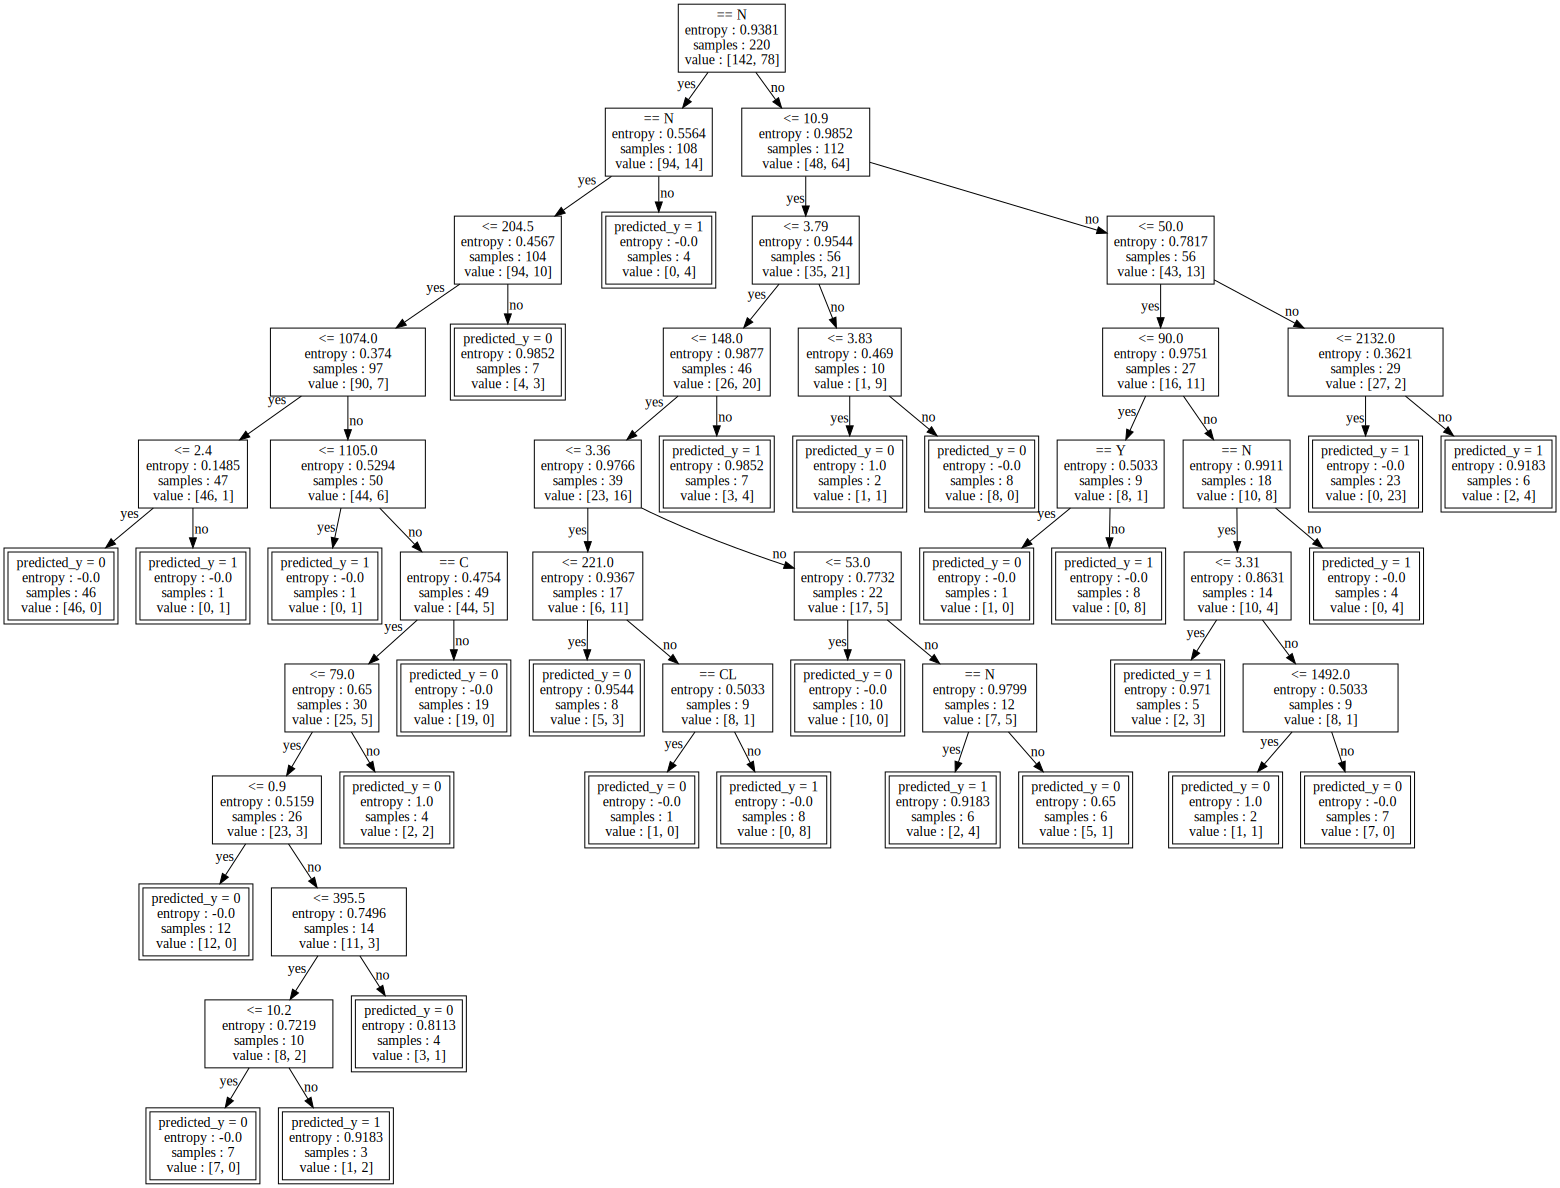

In [ ]:
# images
visualize_tree(clf.root)

# Stable CRI

In [ ]:
from modules.stableCRI import stable_concise_rule_induction # file 제공

dataset = data.copy()
target_name = 'Stage' # target name을 꼭 입력해주시길 바랍니다.
colnm = dataset.columns
X = dataset.loc[:,colnm [colnm != target_name]]
y = dataset.loc[:, target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

# Concatenating X,y -> training dataset([X_train,y_train]), test dataset([X_test,y_test]) 
train_idx, test_idx = X_train.index, X_test.index
df_train, df_test = dataset.loc[train_idx,:], dataset.loc[test_idx,:]

In [ ]:
min_sample_ratio = 0.03
min_samples = round(min_sample_ratio * len(df_train))
max_depth = 100 # 처음에는 2 또는 3으로 설정해서 돌려보고, 소요시간을 체크해보시기 바랍니다.

cri = stable_concise_rule_induction(min_samples = min_samples, max_depth = max_depth)
cri.fit(data = df_train, target_name = target_name, iter_num = 20, rule_rate = 0.9) 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
# predictive performance
# f1 : macro-averaging for multiclass
pred_y, acc, f1 = cri.predict(df_test)
acc,f1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


(0.75, 0.6667)

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, pred_y)
print(cm)

[[35  5]
 [ 9  7]]


In [ ]:
# rules
cri.export_text()

IF ['빌리부빈 < 0.55'] THEN Stage = 0   (homogeneity = 1.0 , coverage = 0.1 )
IF ['복수 == Y'] THEN Stage = 1   (homogeneity = 1.0 , coverage = 0.0727 )
IF ['알부민 >= 4.165'] THEN Stage = 0   (homogeneity = 1.0 , coverage = 0.05 )
IF ['알부민 >= 3.995'] THEN Stage = 0   (homogeneity = 0.9583 , coverage = 0.1091 )
IF ['빌리부빈 >= 0.55', '복수 != Y', '콜레스테롤 >= 1007.5'] THEN Stage = 0   (homogeneity = 1.0 , coverage = 0.0273 )
IF ['인산분해효소 < 510.0'] THEN Stage = 0   (homogeneity = 1.0 , coverage = 0.0273 )
IF ['빌리부빈 >= 0.55', '복수 != Y', '나이 >= 68.5'] THEN Stage = 0   (homogeneity = 0.8333 , coverage = 0.0273 )
IF ['알부민 >= 3.9050000000000002'] THEN Stage = 0   (homogeneity = 0.9143 , coverage = 0.1591 )
IF ['프로트롬빈 < 9.75'] THEN Stage = 0   (homogeneity = 0.8333 , coverage = 0.1091 )
IF ['알부민 < 3.115'] THEN Stage = 1   (homogeneity = 0.6774 , coverage = 0.1409 )
IF ['빌리부빈 >= 0.55', '복수 != Y', '알부민 < 4.165', '알부민 < 3.995', '콜레스테롤 < 1007.5', '인산분해효소 >= 510.0', '나이 < 68.5', '알부민 < 3.9050000000000002', '프로트롬빈 >

In [ ]:
cri.df_concise_rule

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Rule,빌리부빈 < 0.55,알부민 >= 4.165,"빌리부빈 >= 0.55, 복수 != Y, 콜레스테롤 >= 1007.5",인산분해효소 < 510.0,복수 == Y,알부민 >= 3.995,"빌리부빈 >= 0.55, 복수 != Y, 알부민 < 4.165, 알부민 < 3.99...",알부민 >= 3.9050000000000002,"빌리부빈 >= 0.55, 복수 != Y, 알부민 < 4.165, 알부민 < 3.99...","빌리부빈 >= 0.55, 복수 != Y, 나이 >= 68.5",프로트롬빈 < 9.75,알부민 >= 3.7649999999999997,프로트롬빈 < 10.9,혈소판 >= 317.5,프로트롬빈 >= 11.55,"빌리부빈 >= 0.55, 복수 != Y, 알부민 < 4.165, 알부민 < 3.99...",알부민 < 3.115,구리 >= 259.0
pred_y,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,1
Homogeneity,1.0,1.0,1.0,1.0,1.0,0.9583,0.9167,0.9143,0.8333,0.8333,0.8333,0.7931,0.7826,0.7679,0.75,0.7,0.6774,0.6364
Coverage,0.1,0.05,0.0273,0.0273,0.0727,0.1091,0.0682,0.1591,0.0818,0.0273,0.1091,0.2636,0.6273,0.2545,0.1455,0.1818,0.1409,0.05
# of condition,1.0,1.0,3.0,1.0,1.0,1.0,11.0,1.0,11.0,3.0,1.0,1.0,1.0,1.0,1.0,10.0,1.0,1.0


In [ ]:
# dataset not included in rules
cri.others_df

,환자상태,약물,나이,성별,복수,간비대,거미혈관종,부종,빌리부빈,콜레스테롤,알부민,구리,인산분해효소,혈청글루타민산,중성지방,혈소판,프로트롬빈,Stage
136,D,Placebo,59,F,N,Y,N,N,25.5,358.0,3.52,219.0,2468.0,201.50,205.0,151.0,11.5,0
144,D,D-penicillamine,53,M,N,Y,N,N,4.0,196.0,3.45,80.0,2496.0,133.30,142.0,212.0,11.3,1
35,D,Placebo,36,F,N,Y,Y,N,3.3,383.0,3.53,102.0,1234.0,137.95,87.0,234.0,11.0,1
74,D,Placebo,47,F,N,Y,N,N,2.1,262.0,3.48,58.0,2045.0,89.90,84.0,225.0,11.5,1
261,CL,D-penicillamine,56,M,N,Y,N,N,1.2,275.0,3.43,100.0,1142.0,75.00,91.0,217.0,11.3,1
161,C,D-penicillamine,62,F,N,Y,N,N,0.7,187.0,3.48,41.0,654.0,120.90,98.0,164.0,11.0,1
56,D,D-penicillamine,46,M,N,Y,N,N,1.4,427.0,3.70,105.0,1909.0,182.90,171.0,123.0,11.0,0
78,D,D-penicillamine,52,F,N,Y,N,N,2.0,408.0,3.65,50.0,1083.0,110.05,98.0,200.0,11.4,0
54,D,Placebo,62,F,N,Y,N,N,2.1,373.0,3.50,52.0,1009.0,150.35,188.0,178.0,11.0,0
228,CL,Placebo,34,F,N,Y,Y,S,1.1,432.0,3.57,45.0,1406.0,190.00,77.0,248.0,11.4,1


In [ ]:
def _coverage(subset,n):
    return subset.shape[0]/n
def _homogeneity(y):
    _, counts = np.unique(y, return_counts=True)
    ps = counts / len(y)
    return max(ps)
def coverHomo(dataset, target_name, col, operator):         
    coverage = []
    homogeneity = []
    unique_values = np.unique(dataset[col])
    ops = {"<=": (lambda x,y: x<=y), ">=": (lambda x,y: x>=y)}
    for cut_point in unique_values:
        subset = dataset[ops[operator] (dataset[col],cut_point)]
        coverage.append(_coverage(subset[target_name], dataset.shape[0]))
        homogeneity.append(_homogeneity(subset[target_name]))
    return coverage, homogeneity, unique_values

In [ ]:
num_col = data.drop(columns=target_name).select_dtypes(include=['number']).columns.tolist()
print('numeric:',num_col)
cat_col = data.drop(columns=target_name).select_dtypes(include=['object']).columns.tolist()
print('categorical:',cat_col)

numeric: ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
categorical: ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']


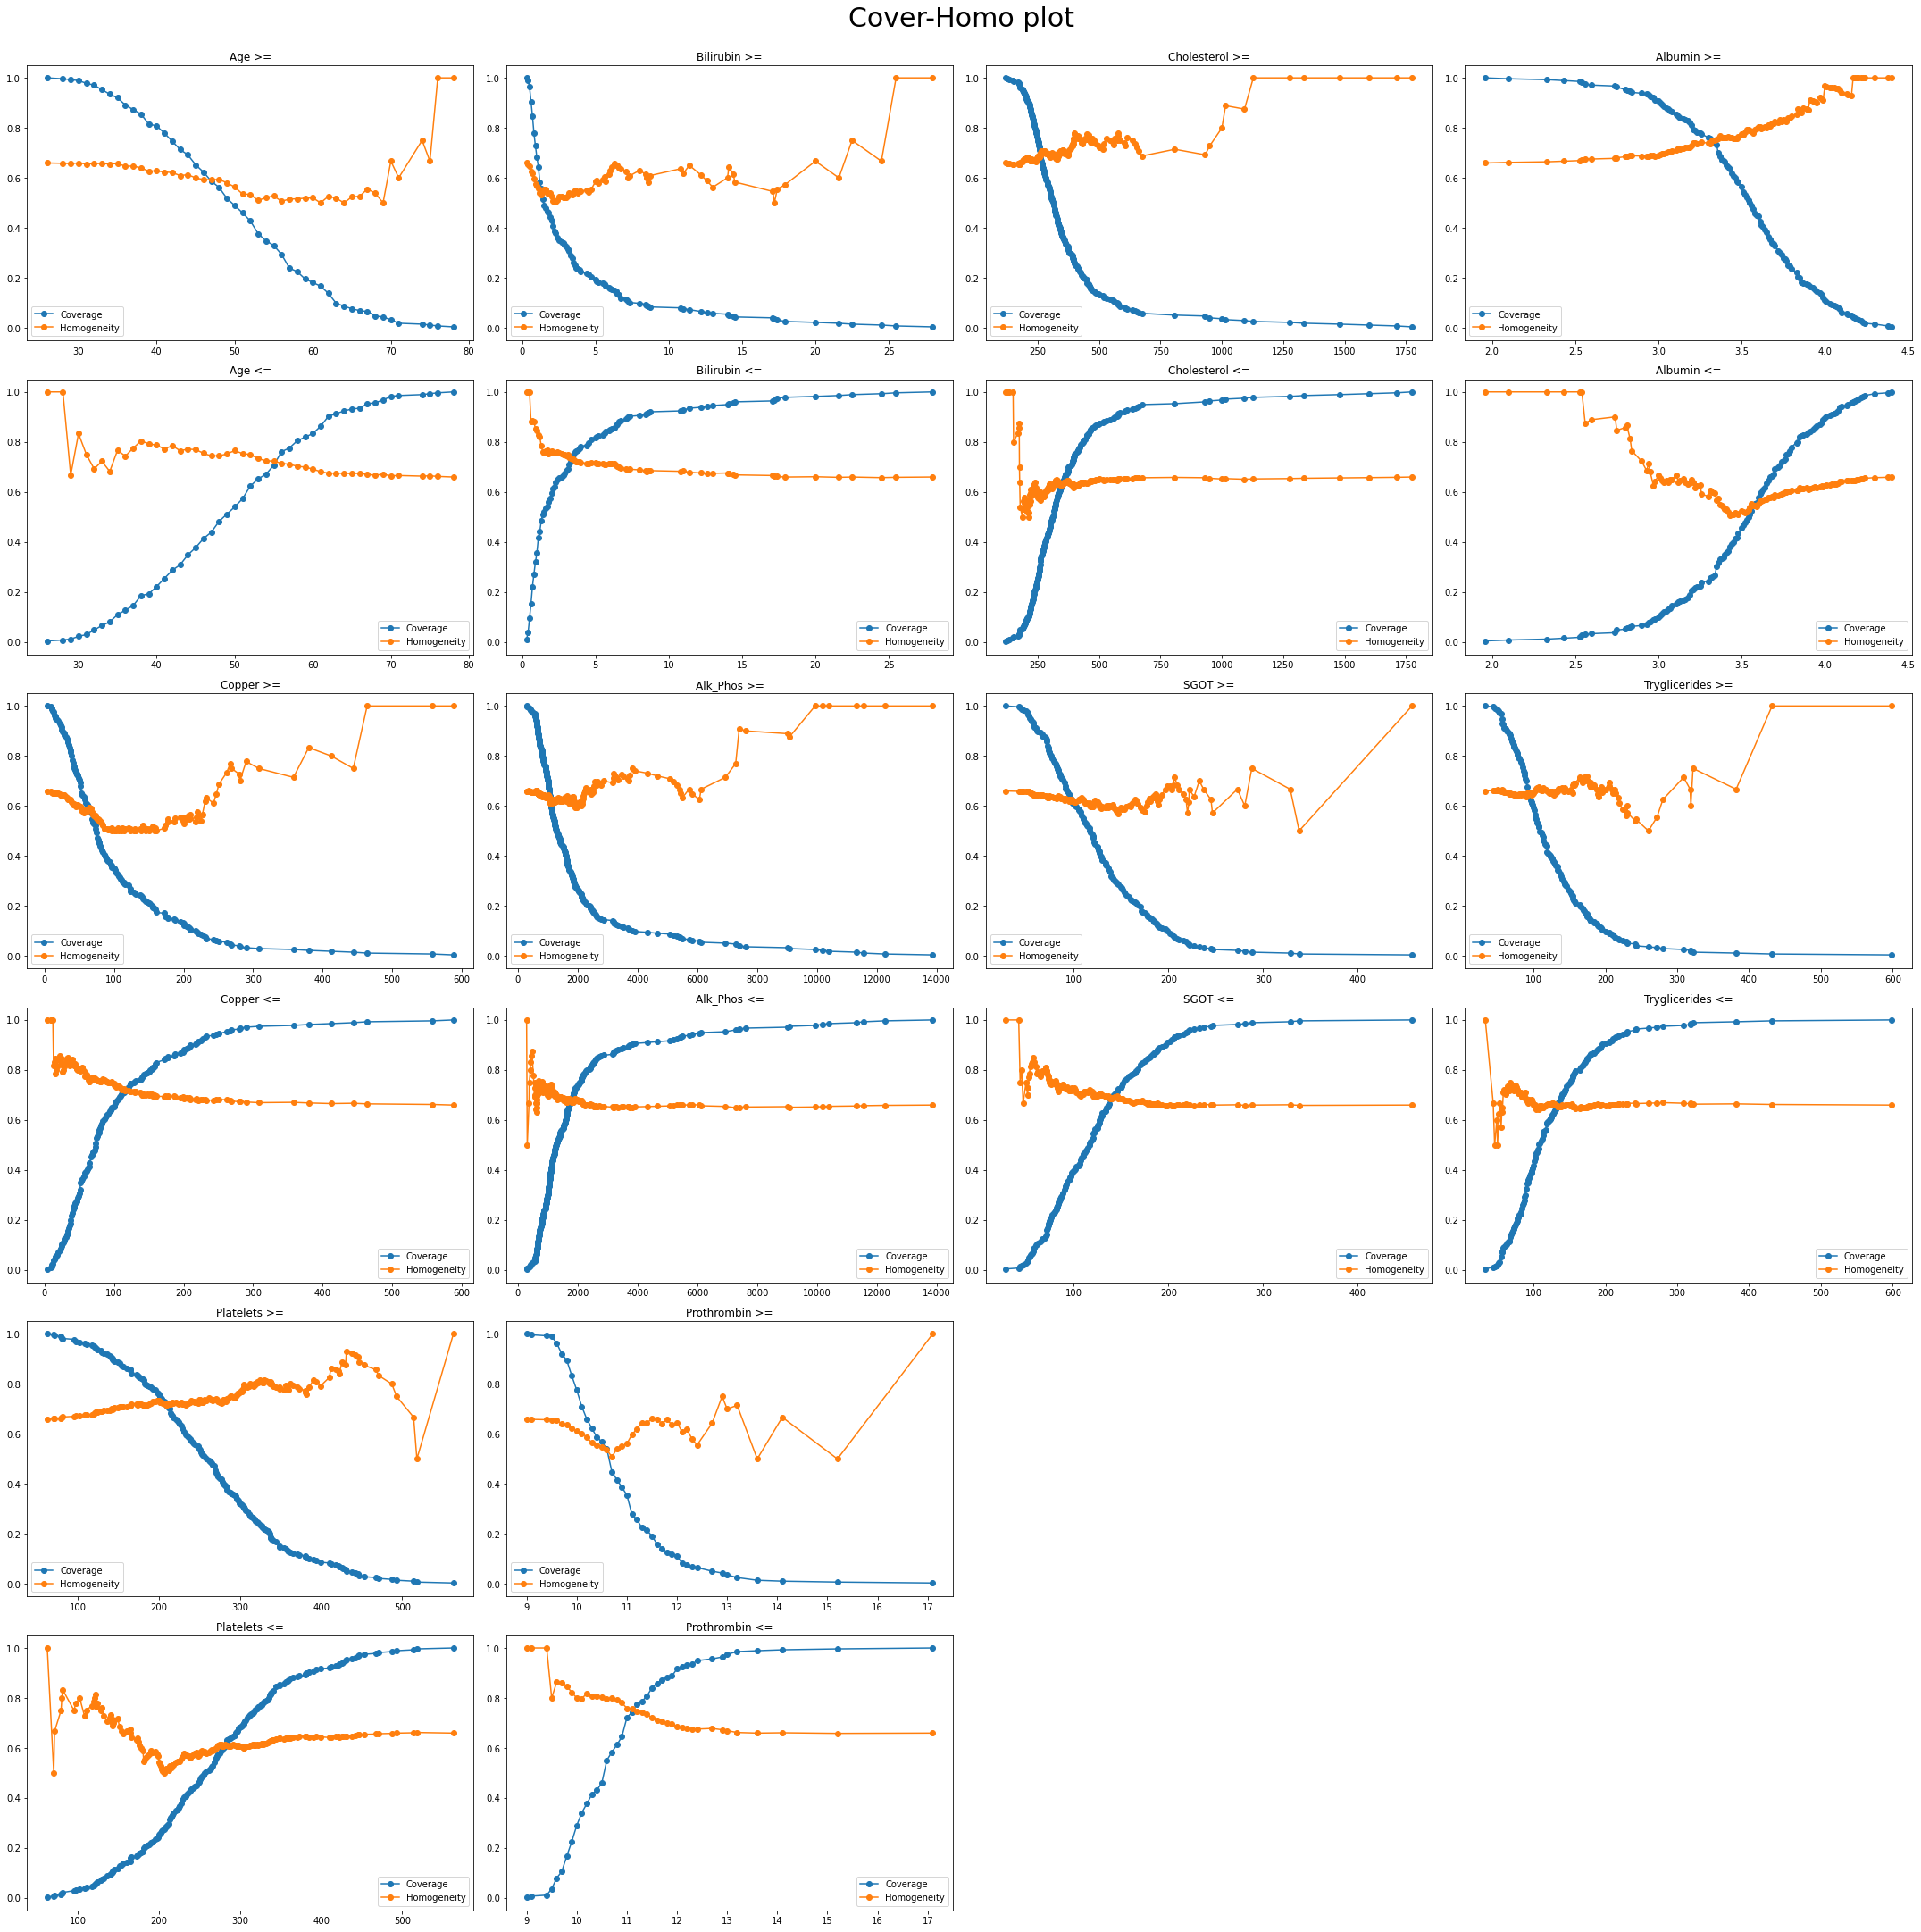

In [ ]:
ncols = 4
nrows = len(num_col) // ncols + (len(num_col) % ncols > 0)
n=1
i=0

plt.figure(figsize=(30, 30)) 
for col in num_col[:]:
    ax1 = plt.subplot(nrows*2, ncols, n+i)
    cover, homo, cut_points = coverHomo(data, target_name, col, '>=')
    ax1.plot(cut_points,cover,'-o')
    ax1.plot(cut_points,homo,'-o')
    ax1.set_title(col +' >=')
    ax1.legend(['Coverage','Homogeneity'])
    ax1.set_ylim(-0.05,1.05)
    
    ax2 = plt.subplot(nrows*2, ncols, n+i+ncols)
    cover, homo, cut_points = coverHomo(data, target_name, col, '<=')
    ax2.plot(cut_points,cover,'-o')
    ax2.plot(cut_points,homo,'-o')
    ax2.set_title(col +' <=')
    ax2.legend(['Coverage','Homogeneity'])
    ax2.set_ylim(-0.05,1.05)
    if n % (ncols) == 0 : i+=ncols
    n+=1

plt.suptitle("Cover-Homo plot", fontsize=30, y=1)
plt.savefig('coverHomo.png', dpi=300, transparent=True) # save figure (dpi=300, transparent=True)
plt.tight_layout()
plt.show()